In [103]:
import pandas as pd
import numpy as np
from docx import Document
import io
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft
from sklearn.inspection import PartialDependenceDisplay

In [38]:
#read the data as a ready
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
store_data = pd.read_csv('store.csv')

C:\Users\murui\AppData\Local\Temp\ipykernel_27272\2998720372.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


In [39]:
doc = Document()
# add title
doc.add_heading('Store Data Summary', level=1)
def output_table(doc, data, head):
    # Add the first few rows of the data
    doc.add_heading(head, level=2)
    table = doc.add_table(rows=1, cols=len(data.columns))
    hdr_cells = table.rows[0].cells
    for i, column in enumerate(data.columns):
        hdr_cells[i].text = column
    for index, row in data.iterrows():
        row_cells = table.add_row().cells
        for i, cell in enumerate(row):
            row_cells[i].text = str(cell)


## Data Description

In [40]:
# check the data
print(store_data.head())
#print to doc
output_table(doc, store_data.head(), "Head of Store Data")

   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth   
0      1         c          a               1270.0                        9.0  \
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear   
0                    2008.0       0              NaN              NaN  \
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,

In [41]:
# check infor
print(store_data.info())
# output store_data to Microsoft Word
buffer = io.StringIO()
store_data.info(buf=buffer)
info_str = buffer.getvalue()
info_lines = info_str.split('\n')[5:-3]  

# Convert information to table format
info_table = pd.DataFrame([line.split() for line in info_lines[1:]], columns=info_lines[0].split())

output_table(doc,info_table, "Info of Store Data")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


In [42]:
# View Statistical Summary of Data
print(store_data.describe())

output_table(doc, store_data.describe(), "Describe of Store Data")



            Store  CompetitionDistance  CompetitionOpenSinceMonth   
count  1115.00000          1112.000000                 761.000000  \
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1

## Feature engineering

### missing value

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


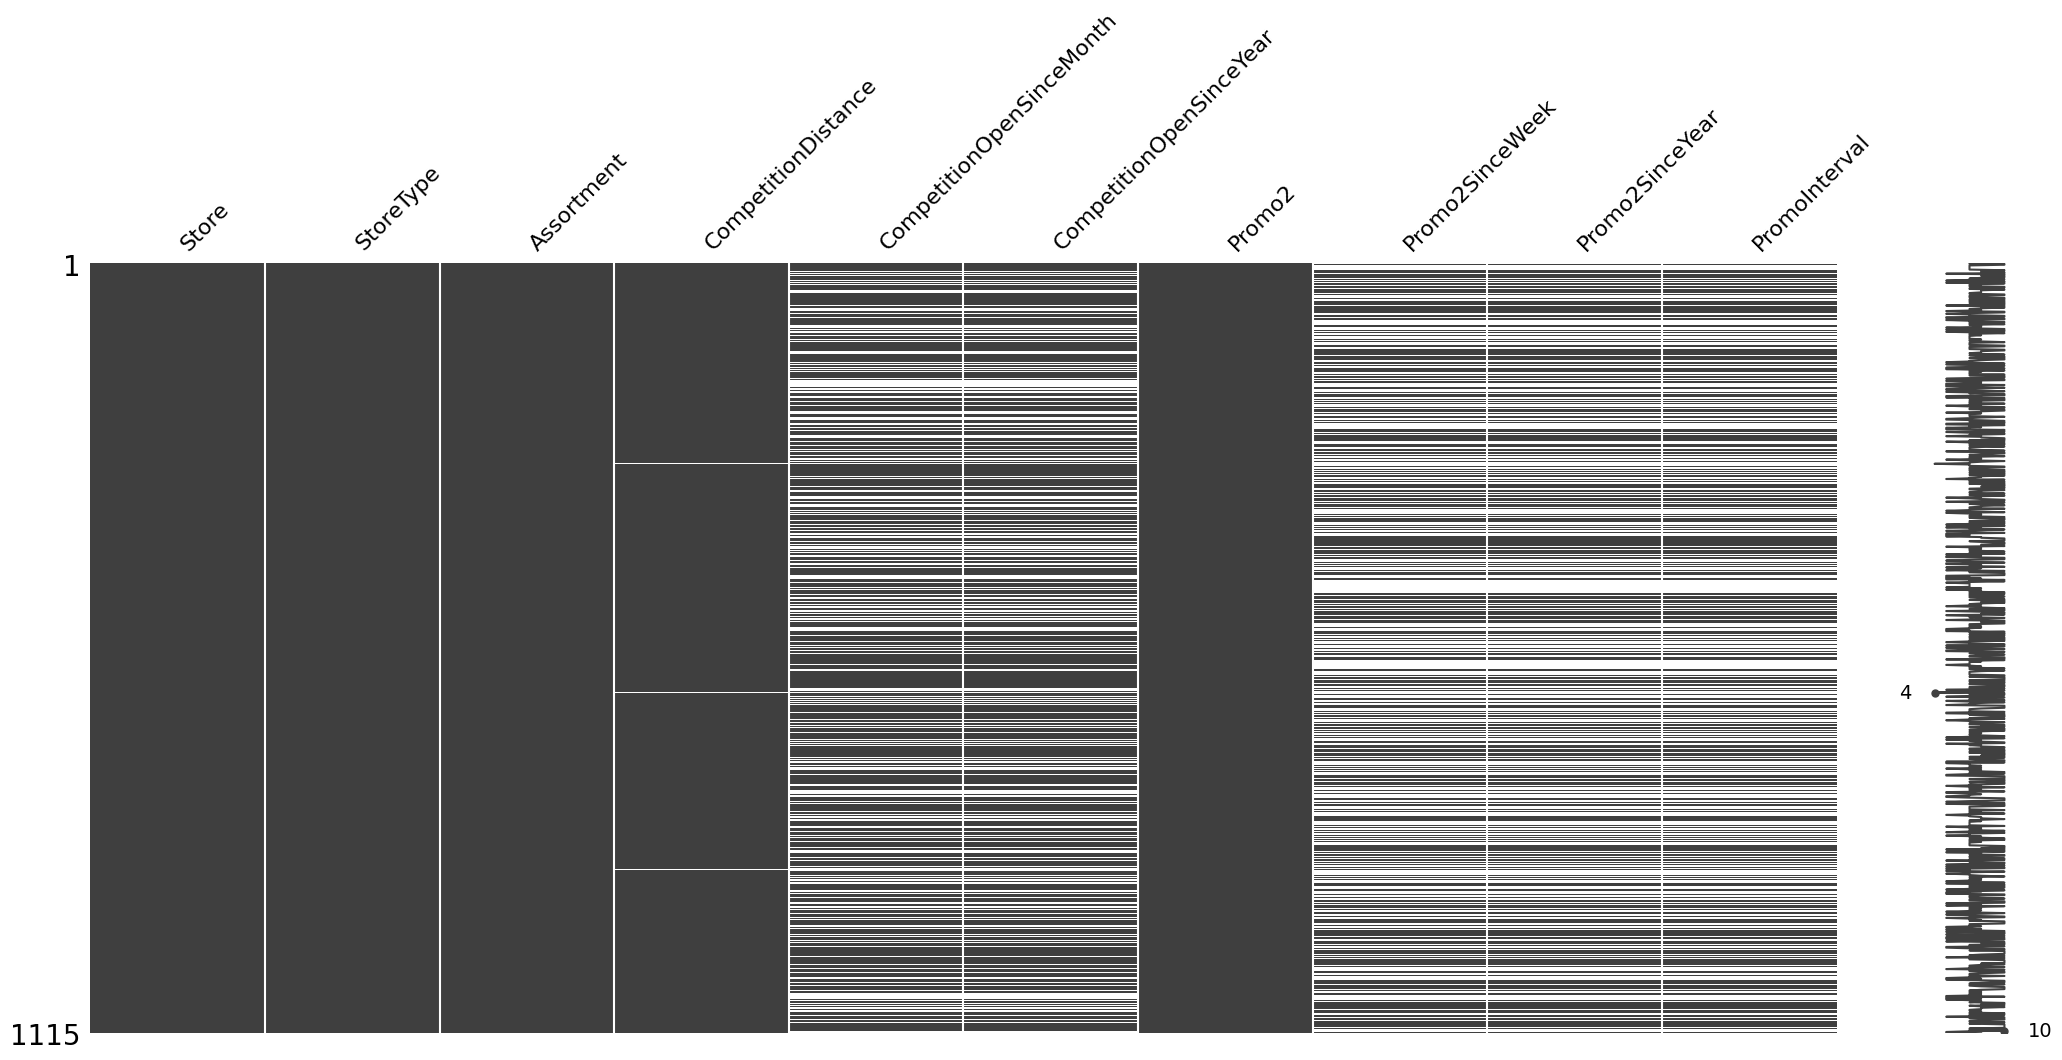

In [43]:
# check missing values
missing_values = store_data.isnull().sum()
print(missing_values)
msno.matrix(store_data)
plt.show()

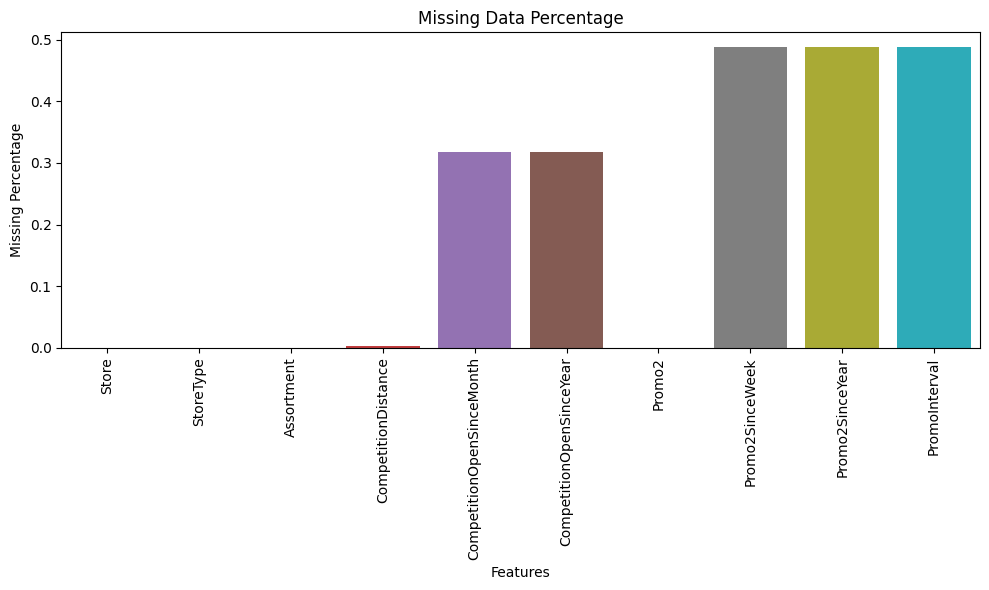

In [44]:
# Calculate the proportion of missing values
missing_percentage = store_data.isnull().sum() / len(store_data)

# Plot the proportion of missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Missing Percentage")
plt.title("Missing Data Percentage")
plt.tight_layout()
plt.show()

In [45]:
# Output the missing value table
missing_table = pd.DataFrame({'Feature': missing_percentage.index, 'Missing Values(%)': missing_percentage.values})
output_table(doc, missing_table, "Missing Values Table")

In [46]:
# Create new variable: Is there a competitor nearby
store_data['HasCompetition'] = store_data['CompetitionDistance'].apply(lambda x: 0 if pd.isna(x) else 1)

# check new variable
print(store_data[['Store', 'CompetitionDistance', 'HasCompetition']].head())

   Store  CompetitionDistance  HasCompetition
0      1               1270.0               1
1      2                570.0               1
2      3              14130.0               1
3      4                620.0               1
4      5              29910.0               1


In [47]:
handel1=store_data[store_data['CompetitionDistance'].isnull()]

In [48]:
output_table(doc, handel1, "handle for competition distance missing value")

In [49]:
train_df = train_df[train_df['Open']!=0]

In [50]:
test_df = test_df[test_df['Open'].notnull()]
test_df.loc[test_df['Open'] == 0, ['Customers', 'Sales']] = 0

In [51]:
filtered_data = train_df[(train_df['Sales'] == 0) & (train_df['Customers'] != 0)]

print(filtered_data)
output_table(doc, filtered_data, "Filtered Data with Sales=0 but other columns not equal to 0")

        Store  DayOfWeek        Date  Sales  Customers  Open  Promo   
478649   1100          2  29/04/2014      0          3     1      1  \
889932    948          4  25/04/2013      0          5     1      1   

       StateHoliday  SchoolHoliday  
478649            0              0  
889932            0              0  


In [52]:
store_data['PromoInterval'].fillna('None', inplace=True)
store_data['Promo2SinceWeek'] = store_data['Promo2SinceWeek'].fillna(0)
store_data['Promo2SinceYear'] = store_data['Promo2SinceYear'].fillna(0)

In [53]:
# Ensure that the date is in datetime format.
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

C:\Users\murui\AppData\Local\Temp\ipykernel_27272\1678962669.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_df['Date'] = pd.to_datetime(train_df['Date'])
C:\Users\murui\AppData\Local\Temp\ipykernel_27272\1678962669.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['Date'] = pd.to_datetime(test_df['Date'])


In [54]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
 10  HasCompetition             1115 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 95.9+ KB


In [55]:
# let StoreType and Assortment to Label Encoding
label_encoder = LabelEncoder()
store_data['StoreType'] = label_encoder.fit_transform(store_data['StoreType'])
store_data['Assortment'] = label_encoder.fit_transform(store_data['Assortment'])
store_data['PromoInterval'] = store_data['PromoInterval'].astype(str)
store_data['PromoInterval'] = label_encoder.fit_transform(store_data['PromoInterval'])

# check
print(store_data['StoreType'].value_counts())
print(store_data['Assortment'].value_counts())
print(store_data['PromoInterval'].value_counts())

StoreType
0    602
3    348
2    148
1     17
Name: count, dtype: int64
Assortment
0    593
2    513
1      9
Name: count, dtype: int64
PromoInterval
3    544
1    335
0    130
2    106
Name: count, dtype: int64


In [56]:
# Convert all values in 'StateHoliday' column to strings
train_df['StateHoliday'] = train_df['StateHoliday'].astype(str)

# Encode the 'StateHoliday' column
train_df['StateHoliday'] = label_encoder.fit_transform(train_df['StateHoliday'])

In [57]:
# Convert all values in 'StateHoliday' column to strings
test_df['StateHoliday'] = test_df['StateHoliday'].astype(str)

# Encode the 'StateHoliday' column
test_df['StateHoliday'] = label_encoder.fit_transform(test_df['StateHoliday'])

### Data consolidation

In [58]:
# merge data sets
train_df = train_df.merge(store_data, on='Store', how='left')
test_df = test_df.merge(store_data, on='Store', how='left')

In [59]:
# create new features
train_df['Year'] = pd.DatetimeIndex(train_df['Date']).year
train_df['Month'] = pd.DatetimeIndex(train_df['Date']).month
train_df['Day'] = pd.DatetimeIndex(train_df['Date']).day
test_df['Year'] = pd.DatetimeIndex(test_df['Date']).year
test_df['Month'] = pd.DatetimeIndex(test_df['Date']).month
test_df['Day'] = pd.DatetimeIndex(test_df['Date']).day

In [60]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  int32         
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  int32         
 10  Assortment                 844392 non-null  int32         
 11  CompetitionDistance        842206 non-null  float64 

In [61]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41077 entries, 0 to 41076
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      41077 non-null  int64         
 1   DayOfWeek                  41077 non-null  int64         
 2   Date                       41077 non-null  datetime64[ns]
 3   Sales                      5984 non-null   float64       
 4   Customers                  5984 non-null   float64       
 5   Open                       41077 non-null  float64       
 6   Promo                      41077 non-null  int64         
 7   StateHoliday               41077 non-null  int32         
 8   SchoolHoliday              41077 non-null  int64         
 9   StoreType                  41077 non-null  int32         
 10  Assortment                 41077 non-null  int32         
 11  CompetitionDistance        40992 non-null  float64       
 12  Comp

## Data visualisation

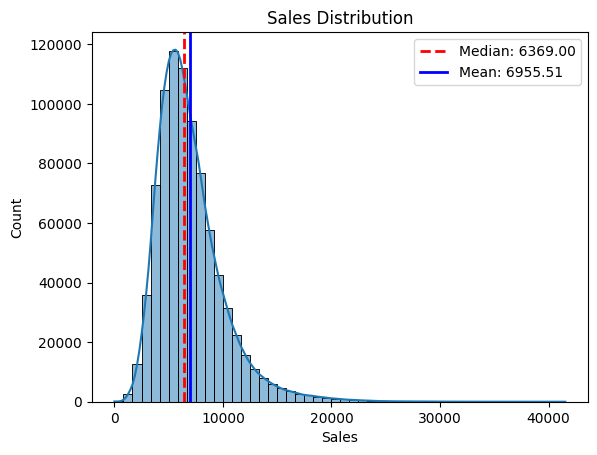

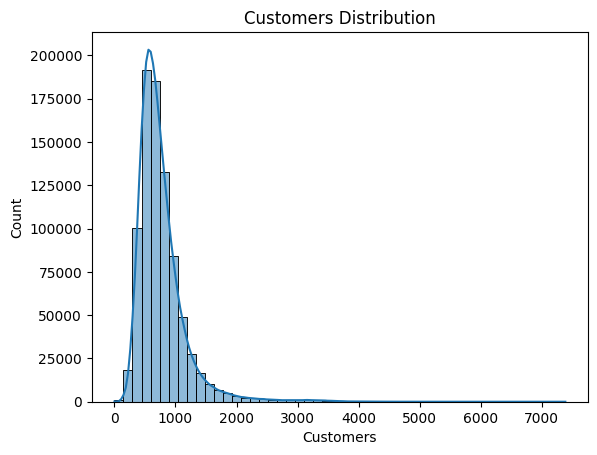

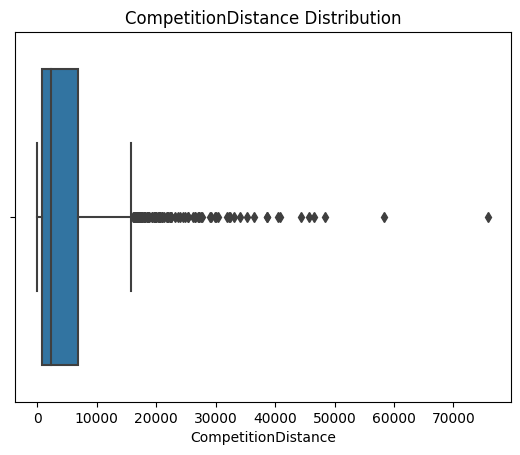

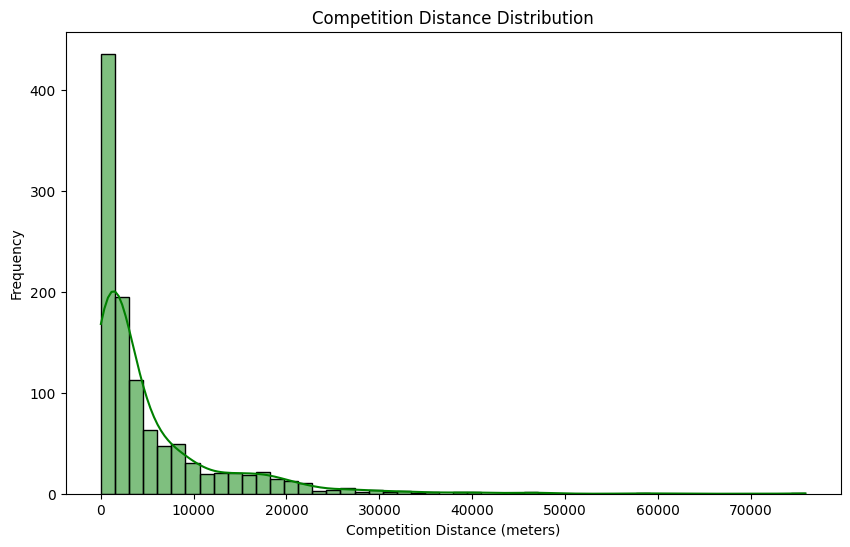

In [62]:
sns.histplot(train_df['Sales'], bins=50, kde=True)
plt.title("Sales Distribution")

# Calculate median and mean
median_sales = train_df['Sales'].median()
mean_sales = train_df['Sales'].mean()

# Add vertical lines for median and mean
plt.axvline(median_sales, color='red', linestyle='--', linewidth=2, label=f'Median: {median_sales:.2f}')
plt.axvline(mean_sales, color='blue', linestyle='-', linewidth=2, label=f'Mean: {mean_sales:.2f}')

# Show legend
plt.legend()

plt.show()

sns.histplot(train_df['Customers'], bins=50, kde=True)
plt.title("Customers Distribution")
plt.show()

# competitive distance distribution
sns.boxplot(x=store_data['CompetitionDistance'])
plt.title("CompetitionDistance Distribution")
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(store_data['CompetitionDistance'].dropna(), bins=50, kde=True, color='green')
plt.title('Competition Distance Distribution')
plt.xlabel('Competition Distance (meters)')
plt.ylabel('Frequency')
plt.show()

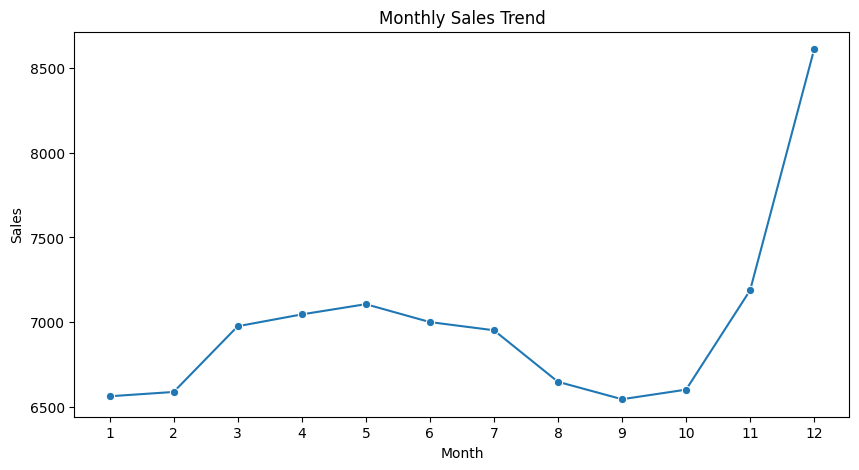

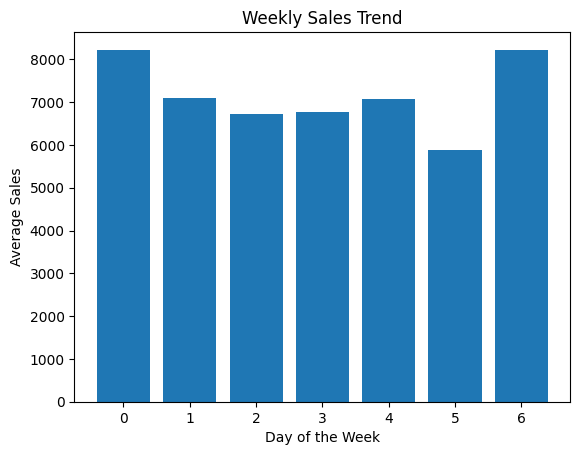

In [63]:
# Sales are aggregated on a monthly basis
train_df['Month'] = train_df['Date'].dt.month
monthly_sales = train_df.groupby('Month')['Sales'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(data=train_df.groupby('Month')['Sales'].mean().reset_index(), x='Month', y='Sales', marker='o')
plt.title("Monthly Sales Trend")
plt.xticks(range(1,13))
plt.show()

# Sales are aggregated on a weekly basis
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek
weekly_sales = train_df.groupby('DayOfWeek')['Sales'].mean()

plt.bar(weekly_sales.index, weekly_sales.values)
plt.title("Weekly Sales Trend")
plt.xlabel("Day of the Week")
plt.ylabel("Average Sales")
plt.show()

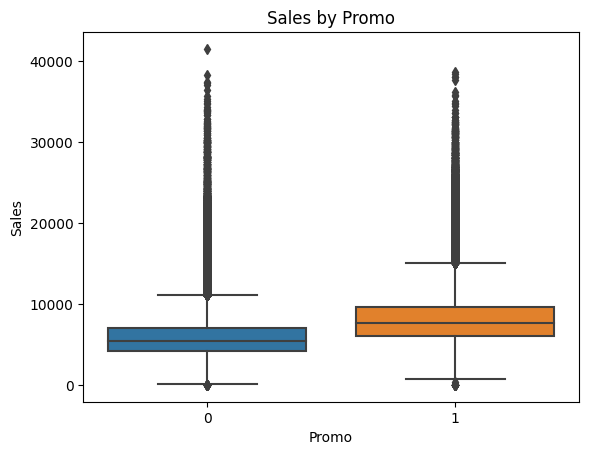

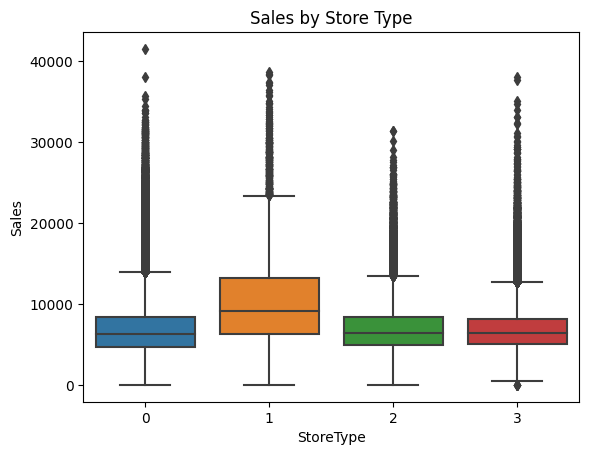

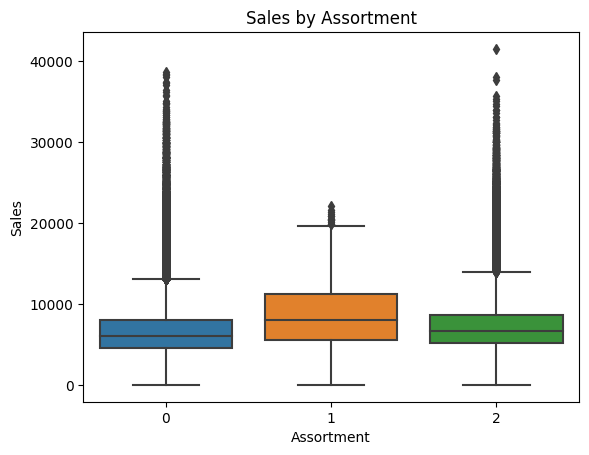

In [64]:
# The relationship between sales and promotional activities
sns.boxplot(data=train_df, x='Promo', y='Sales')
plt.title("Sales by Promo")
plt.show()

# Sales in relation to store type
sns.boxplot(data=train_df, x='StoreType', y='Sales')
plt.title("Sales by Store Type")
plt.show()

# The relationship between sales and product categories
sns.boxplot(data=train_df, x='Assortment', y='Sales')
plt.title("Sales by Assortment")
plt.show()


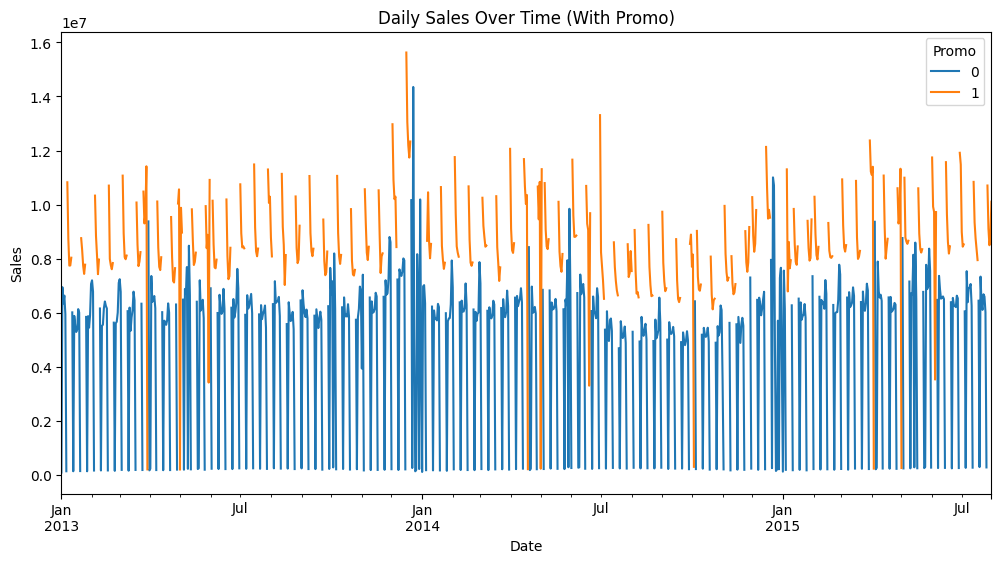

In [65]:
# Aggregate sales by date and whether discounted or not
daily_sales_promo = train_df.groupby(['Date', 'Promo'])['Sales'].sum().unstack()

# Plotting sales trends over time
plt.figure(figsize=(12, 6))
daily_sales_promo.plot(ax=plt.gca())
plt.title('Daily Sales Over Time (With Promo)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Promo')
plt.show()

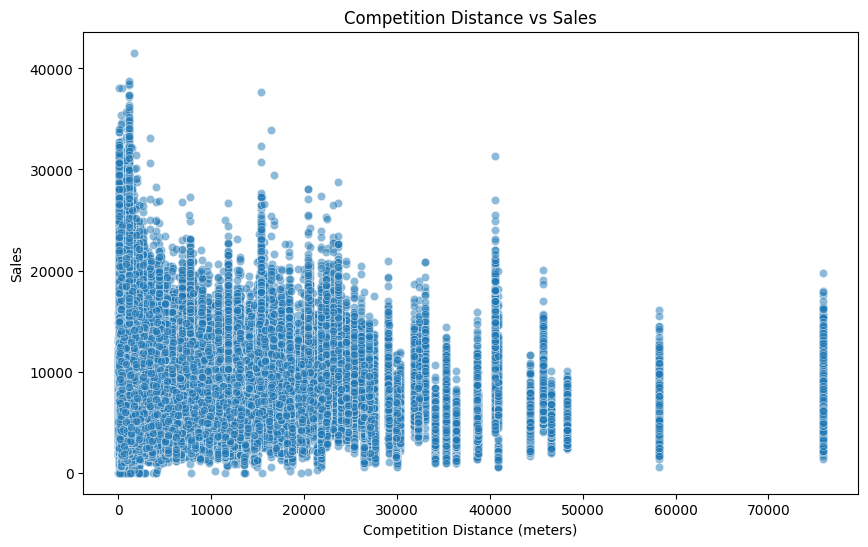

In [66]:
# Plot the relationship between CompetitionDistance and Sales.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=train_df, alpha=0.5)
plt.title('Competition Distance vs Sales')
plt.xlabel('Competition Distance (meters)')
plt.ylabel('Sales')
plt.show()

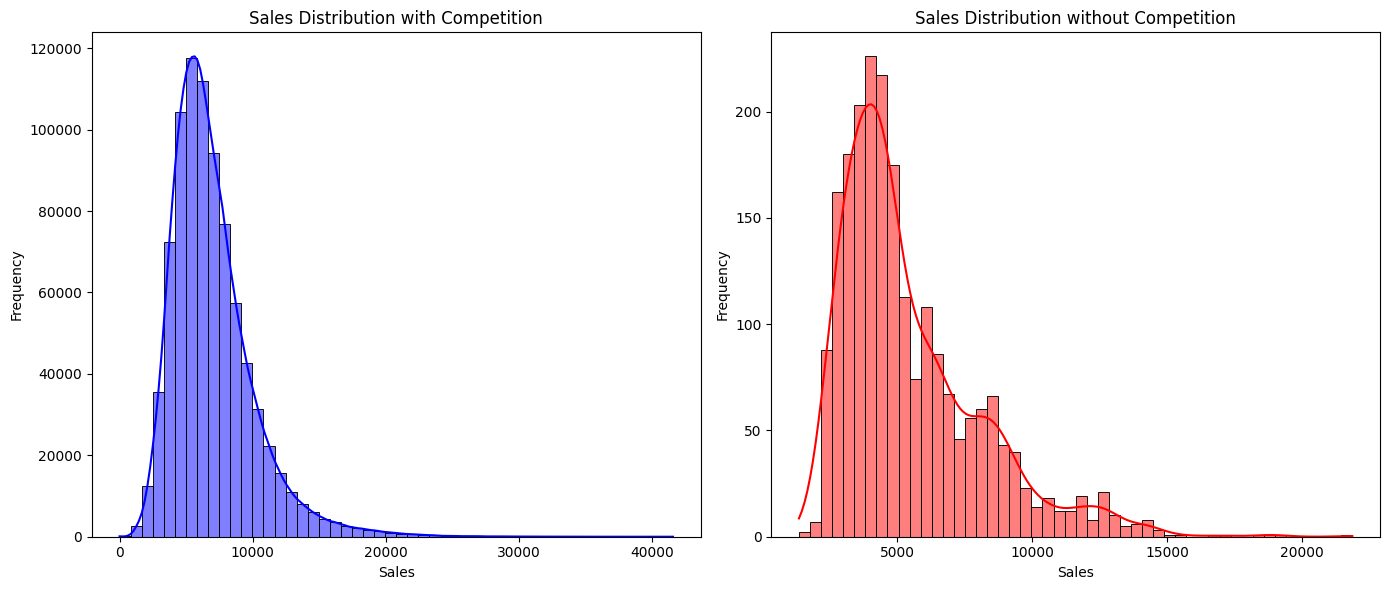

In [67]:
plt.figure(figsize=(14, 6))

# Sales distribution by competitor
plt.subplot(1, 2, 1)
sns.histplot(train_df[train_df['HasCompetition'] == 1]['Sales'], bins=50, kde=True, color='blue')
plt.title('Sales Distribution with Competition')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Sales distribution by no competitor
plt.subplot(1, 2, 2)
sns.histplot(train_df[train_df['HasCompetition'] == 0]['Sales'], bins=50, kde=True, color='red')
plt.title('Sales Distribution without Competition')
plt.xlabel('Sales')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

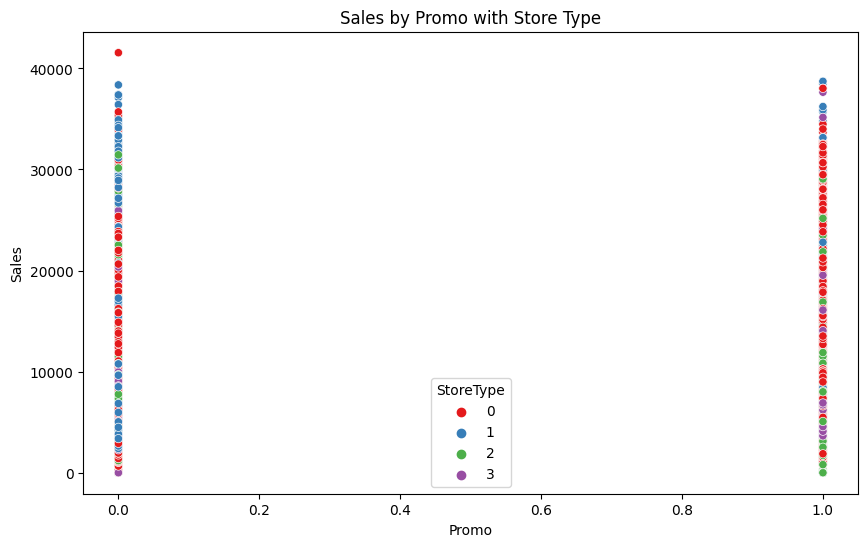

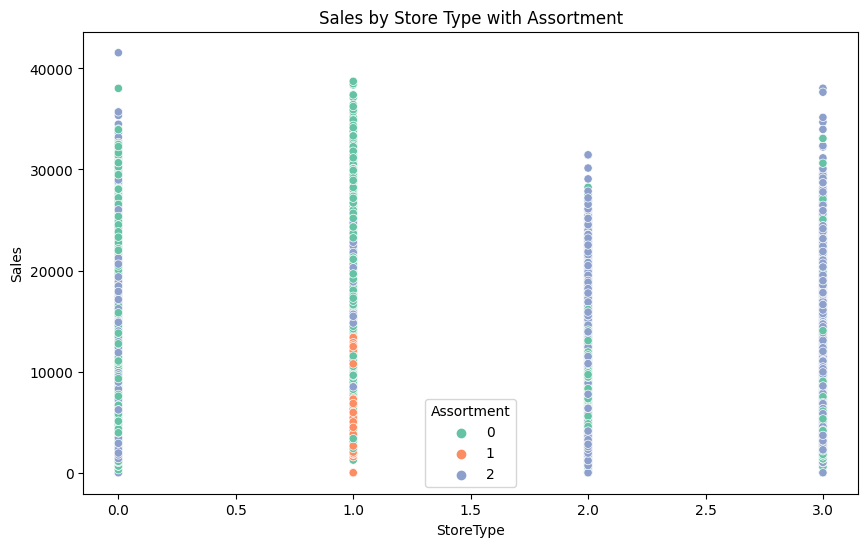

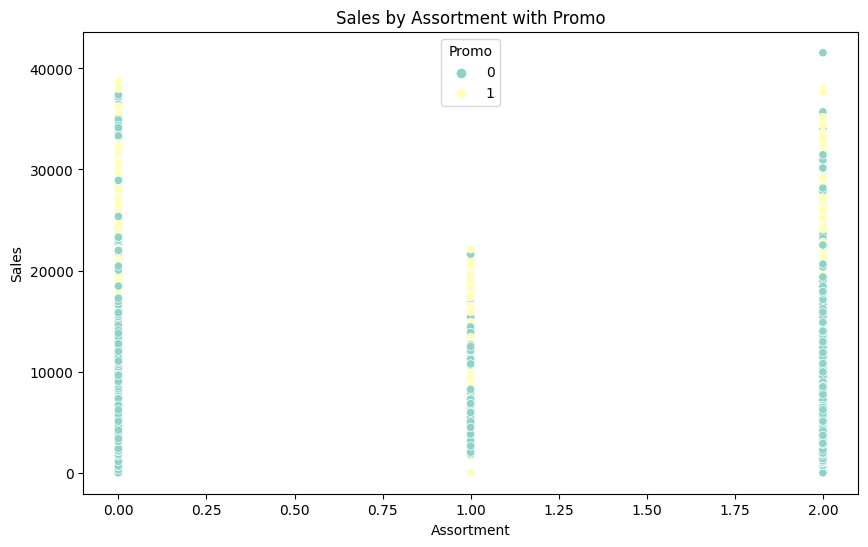

In [ ]:
# Relationship between sales and promotional activities (scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='Promo', y='Sales', hue='StoreType', palette='Set1')
plt.title("Sales by Promo with Store Type")
plt.show()

# Relationship between sales and store type (scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='StoreType', y='Sales', hue='Assortment', palette='Set2')
plt.title("Sales by Store Type with Assortment")
plt.show()

#Relationship between sales and product category (scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='Assortment', y='Sales', hue='Promo', palette='Set3')
plt.title("Sales by Assortment with Promo")
plt.show()

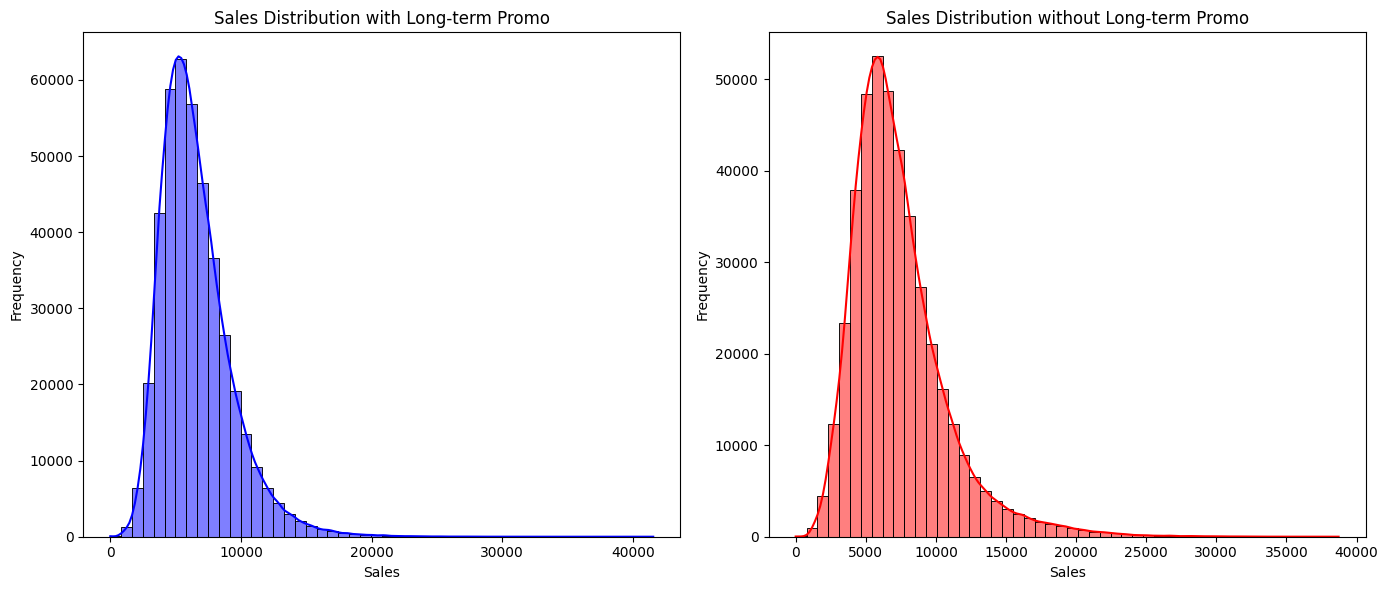

In [ ]:
plt.figure(figsize=(14, 6))

# Sales breakdown by long-term promotion
plt.subplot(1, 2, 1)
sns.histplot(train_df[train_df['Promo2'] == 1]['Sales'], bins=50, kde=True, color='blue')
plt.title('Sales Distribution with Long-term Promo')
plt.xlabel('Sales')
plt.ylabel('Frequency')

#Sales breakdown without participation in long-term promotions
plt.subplot(1, 2, 2)
sns.histplot(train_df[train_df['Promo2'] == 0]['Sales'], bins=50, kde=True, color='red')
plt.title('Sales Distribution without Long-term Promo')
plt.xlabel('Sales')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

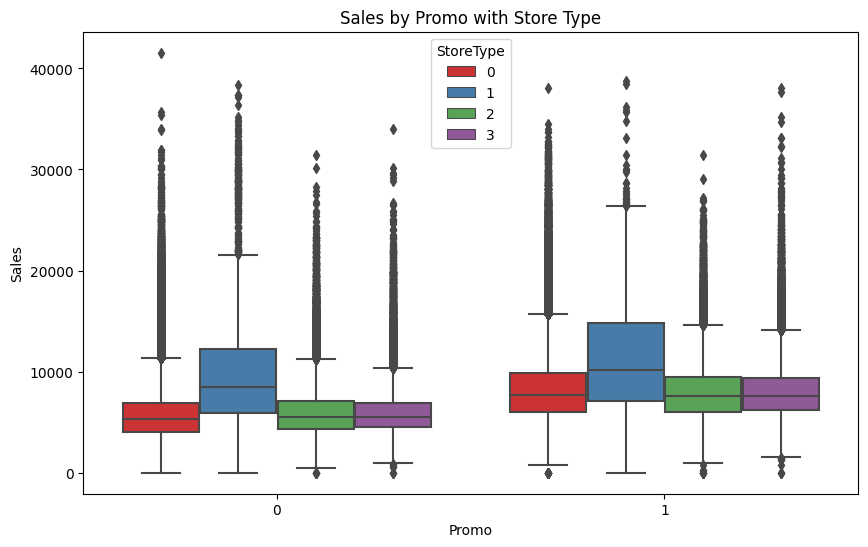

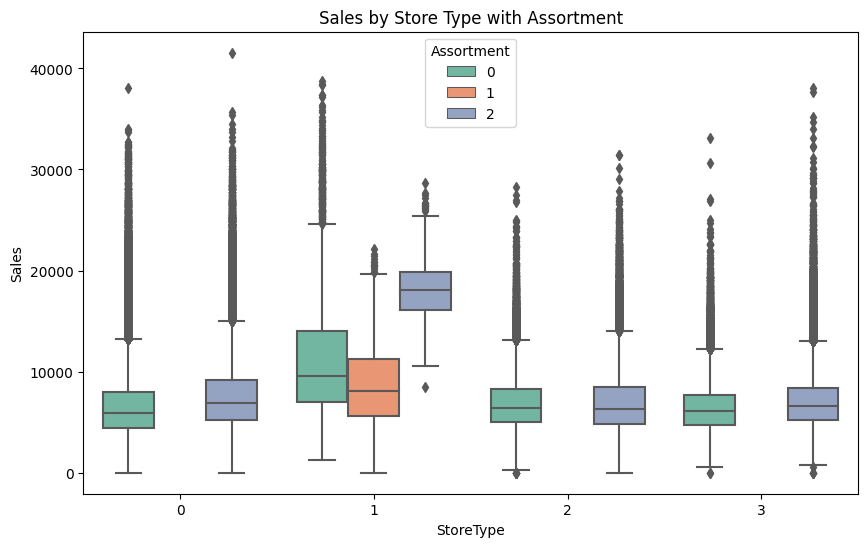

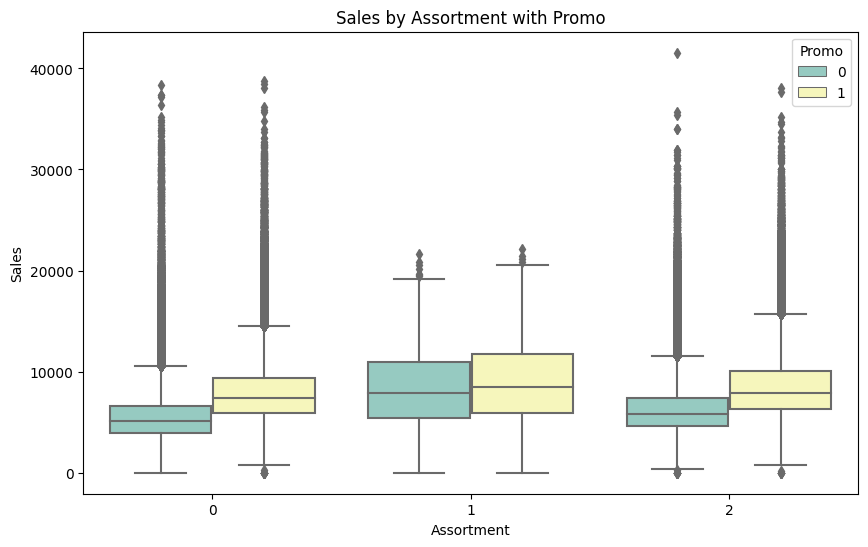

In [ ]:
# Relationship between sales and promotional activities (box plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Promo', y='Sales', hue='StoreType', palette='Set1')
plt.title("Sales by Promo with Store Type")
plt.show()

# Sales in relation to store type (box plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='StoreType', y='Sales', hue='Assortment', palette='Set2')
plt.title("Sales by Store Type with Assortment")
plt.show()

# Relationship between sales and product categories (box plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Assortment', y='Sales', hue='Promo', palette='Set3')
plt.title("Sales by Assortment with Promo")
plt.show()

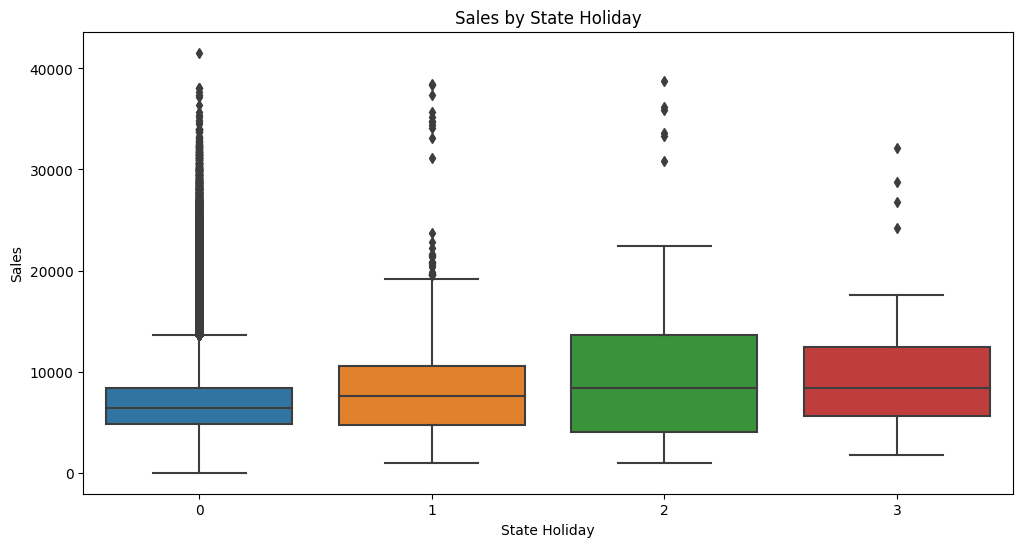

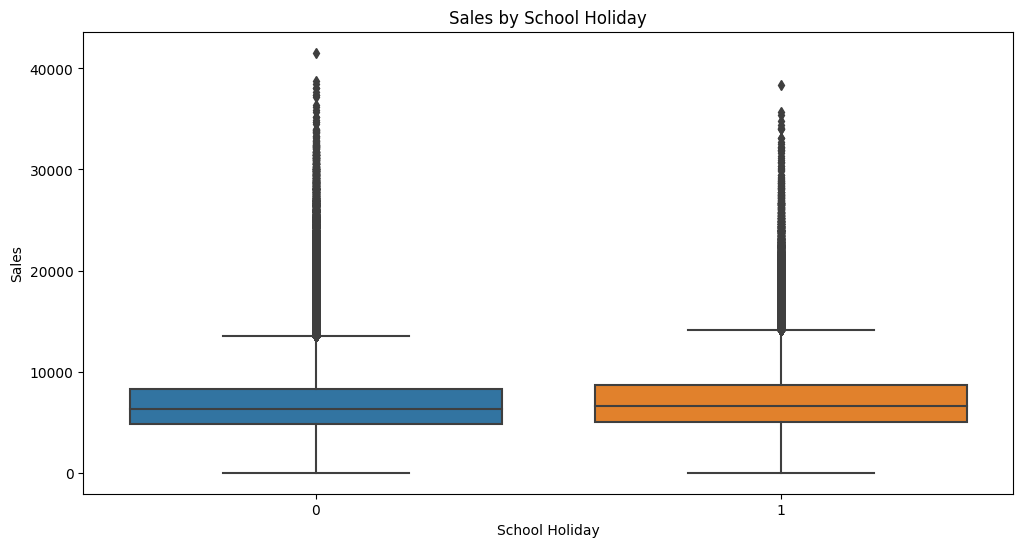

In [ ]:
# Visualising the impact of public holidays on sales
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='StateHoliday', y='Sales')
plt.title("Sales by State Holiday")
plt.xlabel("State Holiday")
plt.ylabel("Sales")
plt.show()

#  Visualising the impact of school holidays on sales
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='SchoolHoliday', y='Sales')
plt.title("Sales by School Holiday")
plt.xlabel("School Holiday")
plt.ylabel("Sales")
plt.show()

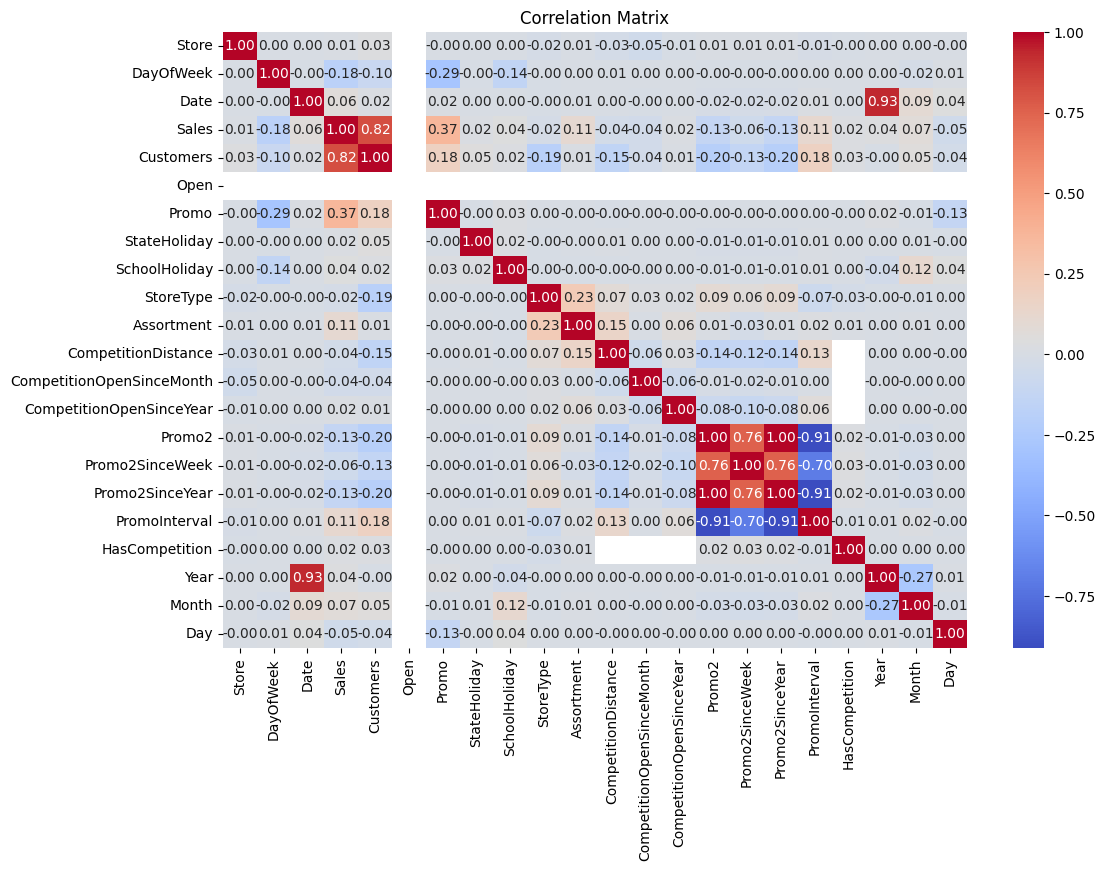

In [ ]:
#Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Visualising correlation matrices
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

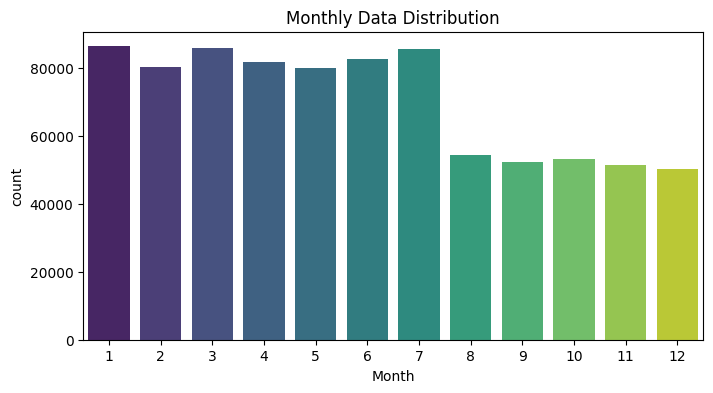

In [ ]:
# Univariate: distribution by month
plt.figure(figsize=(8,4))
sns.countplot(data=train_df, x='Month', palette='viridis')
plt.title("Monthly Data Distribution")
plt.show()

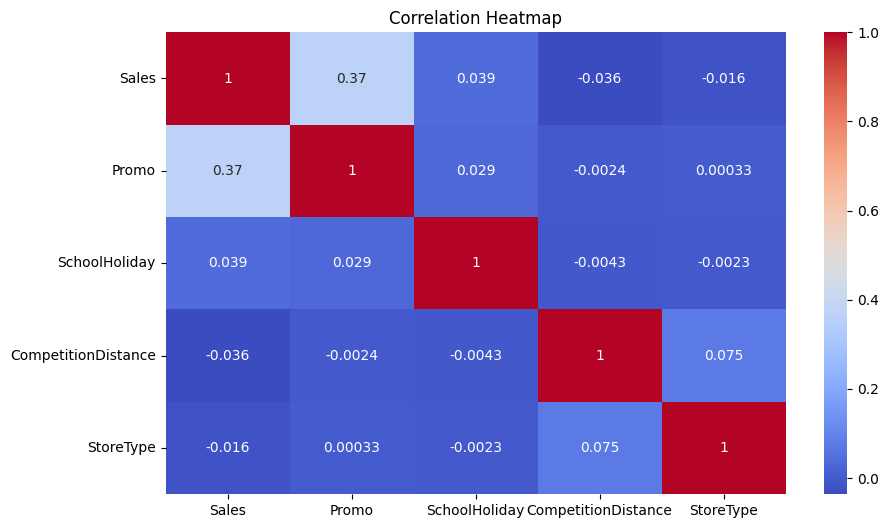

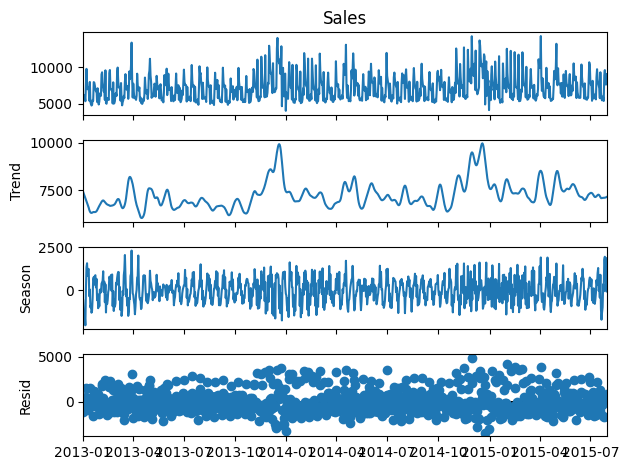

In [ ]:
# Heat map: multi-factor correlation
plt.figure(figsize=(10,6))
corr_matrix = train_df[['Sales', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'StoreType']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

ts = train_df.groupby('Date')['Sales'].mean()
result = STL(ts, period=12).fit()
result.plot()
plt.show()

<Figure size 1200x600 with 0 Axes>

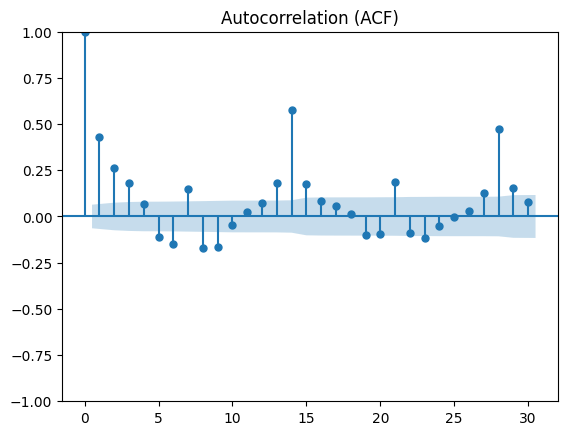

<Figure size 1200x600 with 0 Axes>

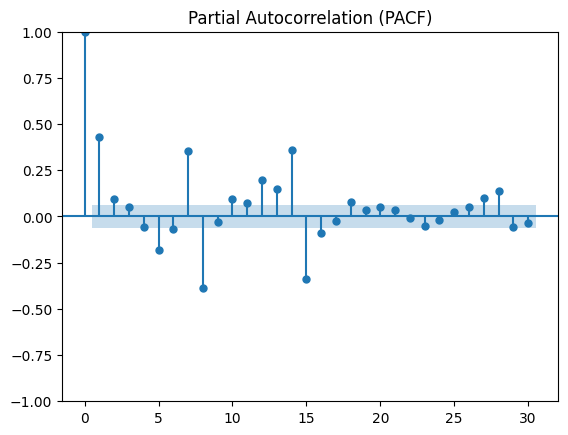

In [ ]:
# Aggregate by date to daily sales (assuming that missing values have been processed)
ts_daily = train_df.groupby('Date')['Sales'].mean()

# Plot ACF and PACF (set maximum lag to seasonal period, e.g. monthly period = 30 days)
plt.figure(figsize=(12, 6))
plot_acf(ts_daily, lags=30, alpha=0.05, title='Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(ts_daily, lags=30, alpha=0.05, title='Partial Autocorrelation (PACF)')
plt.show()

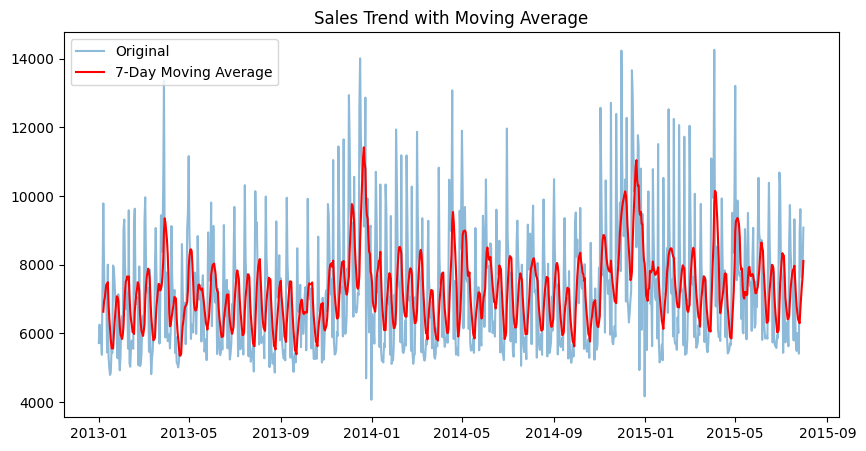

In [ ]:
# Calculation of 7-day moving average (weekly trend)
ts_ma = ts_daily.rolling(window=7).mean()

plt.figure(figsize=(10,5))
plt.plot(ts_daily, label='Original', alpha=0.5)
plt.plot(ts_ma, label='7-Day Moving Average', color='red')
plt.title("Sales Trend with Moving Average")
plt.legend()
plt.show()

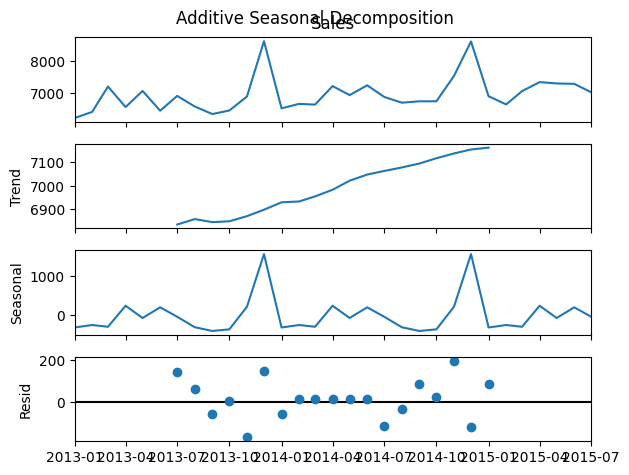

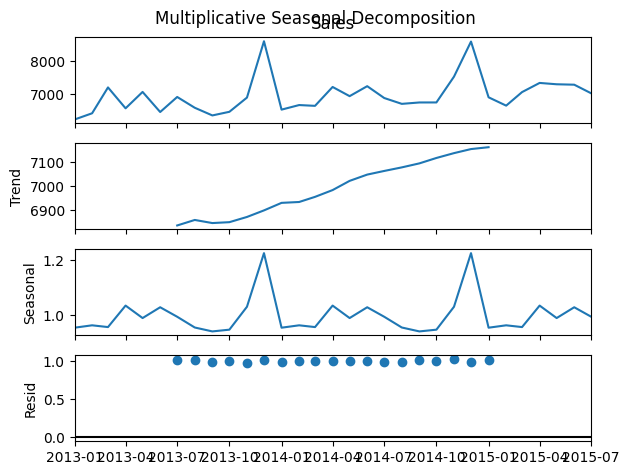

In [ ]:
# Aggregation by month (assuming monthly data)
ts_monthly = train_df.groupby(['Year', 'Month'])['Sales'].mean().reset_index()
ts_monthly['Date'] = pd.to_datetime(ts_monthly[['Year', 'Month']].assign(day=1))
ts_monthly = ts_monthly.set_index('Date')['Sales']

# Additive model decomposition
result_add = seasonal_decompose(ts_monthly, model='additive', period=12)
result_add.plot()
plt.suptitle("Additive Seasonal Decomposition")
plt.show()

# Decomposition of the multiplicative model (applicable when seasonal fluctuations increase with the trend)
result_mul = seasonal_decompose(ts_monthly, model='multiplicative', period=12)
result_mul.plot()
plt.suptitle("Multiplicative Seasonal Decomposition")
plt.show()

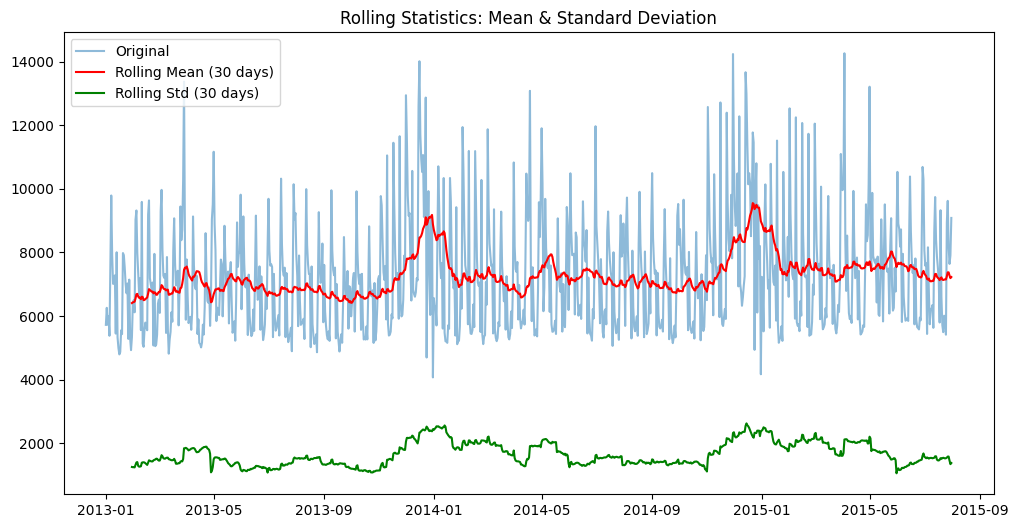

In [ ]:
# Rolling average and standard deviation (window = 30 days)
rolling_mean = ts_daily.rolling(window=30).mean()
rolling_std = ts_daily.rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(ts_daily, label='Original', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='red')
plt.plot(rolling_std, label='Rolling Std (30 days)', color='green')
plt.title("Rolling Statistics: Mean & Standard Deviation")
plt.legend()
plt.show()

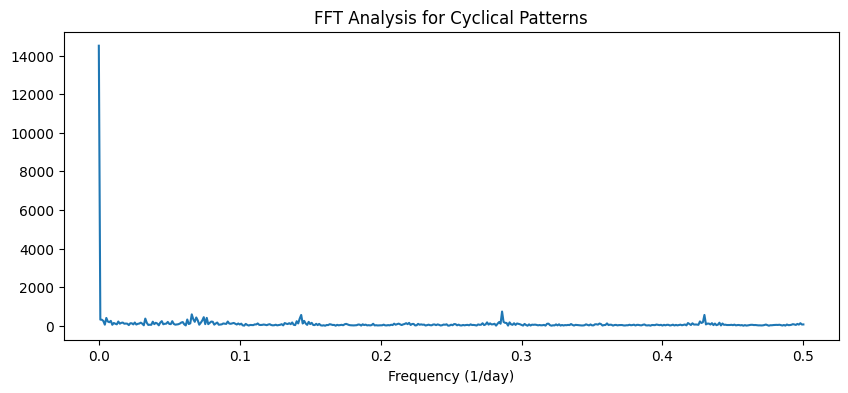

In [ ]:
# Fourier transform analysis (requires continuous data without missing values)
ts_clean = ts_daily.dropna()
yf = fft(ts_clean.values)
N = len(ts_clean)
xf = np.linspace(0, 1/(2*1), N//2)  

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlabel('Frequency (1/day)')
plt.title("FFT Analysis for Cyclical Patterns")
plt.show()

## Model

In [80]:
df = train_df.copy()

features = df.drop(['Sales','Customers'], axis=1).select_dtypes(include=np.number).columns
target = ['Sales','Customers']

median_distance = df['CompetitionDistance'].median()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(median_distance)
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0)
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(0)

In [81]:
df2 = test_df[test_df['Open']==1].copy()

median_distance = df2['CompetitionDistance'].median()
df2['CompetitionDistance'] = df2['CompetitionDistance'].fillna(median_distance)
df2['CompetitionOpenSinceMonth'] = df2['CompetitionOpenSinceMonth'].fillna(0)
df2['CompetitionOpenSinceYear'] = df2['CompetitionOpenSinceYear'].fillna(0)

In [82]:
# Divide the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42
)

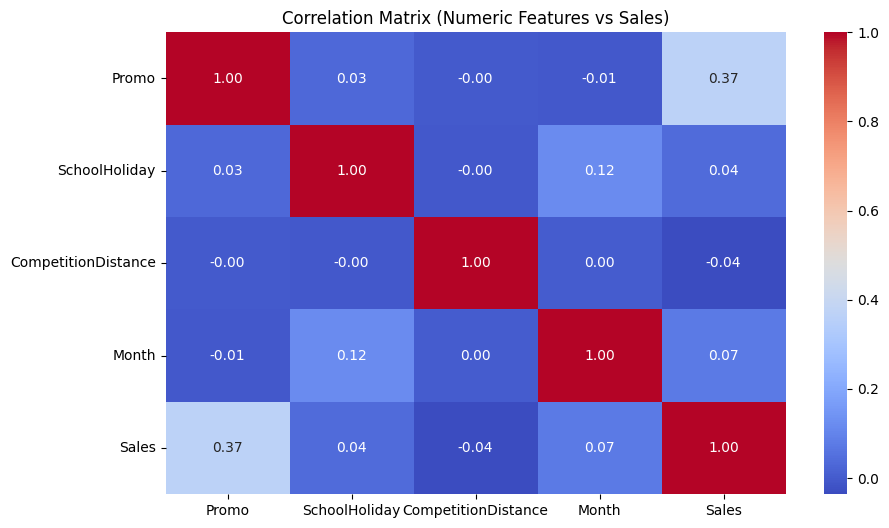

In [ ]:
numeric_features = ['Promo', 'SchoolHoliday', 'CompetitionDistance', 'Month']
corr_matrix = train_df[numeric_features + ['Sales']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric Features vs Sales)")
plt.show()

In [84]:
def calculate_rmspe(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # avoid division by zero
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    
    # Calculate percentage error
    percentage_error = (y_true - y_pred) / y_true
    
    # Calculate the root mean square percentage error
    rmspe = np.sqrt(np.mean(percentage_error ** 2)) * 100
    
    return rmspe

R² Score: 0.924
RMSPE: 25.92%

Feature Importance:
CompetitionDistance          0.202386
Store                        0.174246
Promo                        0.134207
CompetitionOpenSinceYear     0.074910
DayOfWeek                    0.074669
CompetitionOpenSinceMonth    0.066193
Day                          0.053915
Month                        0.049088
StoreType                    0.034265
Promo2SinceWeek              0.032457
Assortment                   0.030943
Promo2SinceYear              0.030317
Year                         0.017172
PromoInterval                0.013962
SchoolHoliday                0.006495
Promo2                       0.002620
StateHoliday                 0.001777
HasCompetition               0.000377
Open                         0.000000
dtype: float64


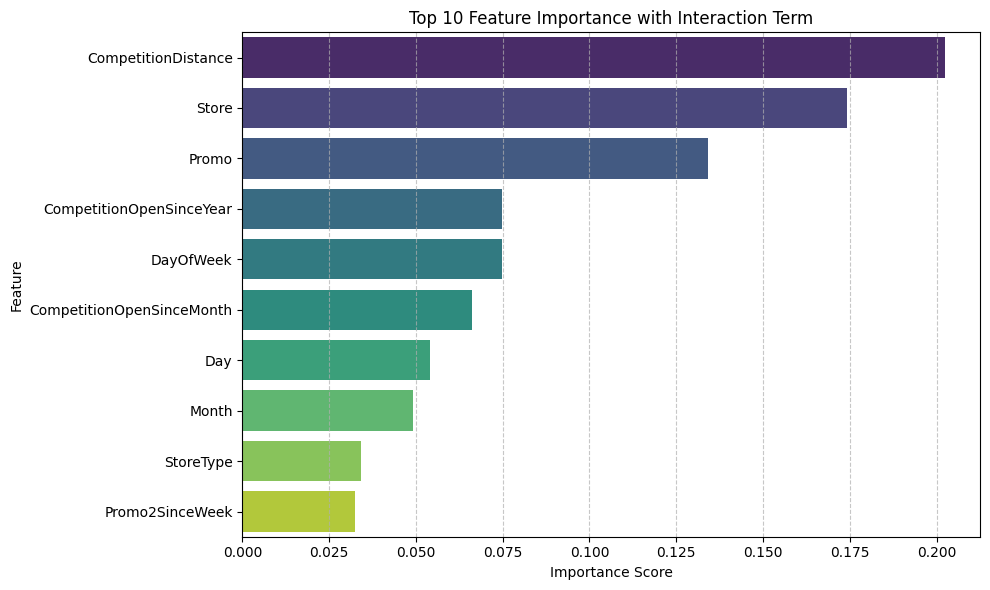

In [ ]:
# train model
rf = RandomForestRegressor(n_estimators=10,random_state=42)
rf.fit(X_train, y_train)

# access the model
y_pred = rf.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")

# calculate RMSPE
rmspe = calculate_rmspe(y_test, y_pred)
print(f"RMSPE: {rmspe:.2f}%")


# feature importance
importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance:")
print(importance)

# Visualize feature importance
importance = rf.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)



plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Feature Importance with Interaction Term')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

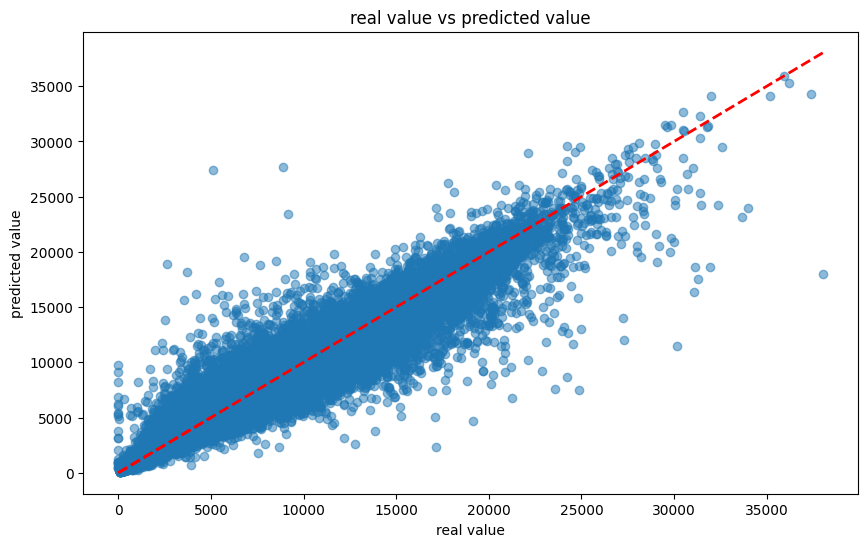

In [86]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Visualise the scatterplot of predicted and true values.
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('real value')
plt.ylabel('predicted value')
plt.title('real value vs predicted value')
plt.show()

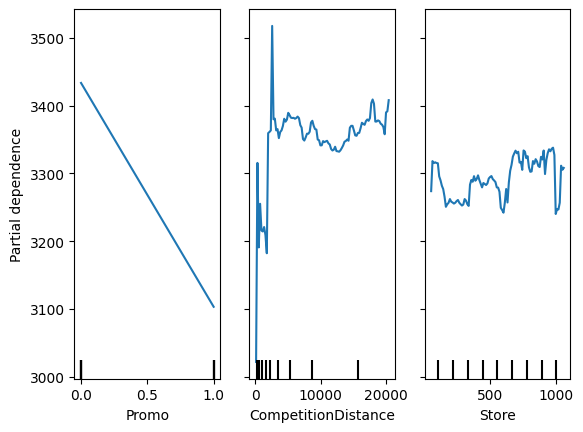

In [ ]:
# Partial dependency mapping
features2 = ['Promo', 'CompetitionDistance','Store']  # choose features to plot
PartialDependenceDisplay.from_estimator(rf, X_train, features2, feature_names=X_train.columns)
plt.show()

In [ ]:
def rmse_scorer(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(mean_squared_error(y, y_pred))

#  cross validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=rmse_scorer)


print(f"Std RMSE: {np.std(cv_scores):.2f}")


# Prediction on the training set
y_train_pred = rf.predict(X_train)
rmspe_train = calculate_rmspe(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"R² Score: {r2:.4f}")
print(f"RMSPE: {rmspe_train:.2f}%")


feature_importances = pd.Series(rf.feature_importances_,
                               index=X_train.columns).sort_values(ascending=False)


print("\nFeature Importances:")
for feature, importance in feature_importances.items():
    print(f"{feature:<25} {importance:.6f}")

print("\ndtype:", feature_importances.dtype)

Std RMSE: 2.92
R² Score: 0.9860
RMSPE: 20.66%

Feature Importances:
CompetitionDistance       0.202386
Store                     0.174246
Promo                     0.134207
CompetitionOpenSinceYear  0.074910
DayOfWeek                 0.074669
CompetitionOpenSinceMonth 0.066193
Day                       0.053915
Month                     0.049088
StoreType                 0.034265
Promo2SinceWeek           0.032457
Assortment                0.030943
Promo2SinceYear           0.030317
Year                      0.017172
PromoInterval             0.013962
SchoolHoliday             0.006495
Promo2                    0.002620
StateHoliday              0.001777
HasCompetition            0.000377
Open                      0.000000

dtype: float64


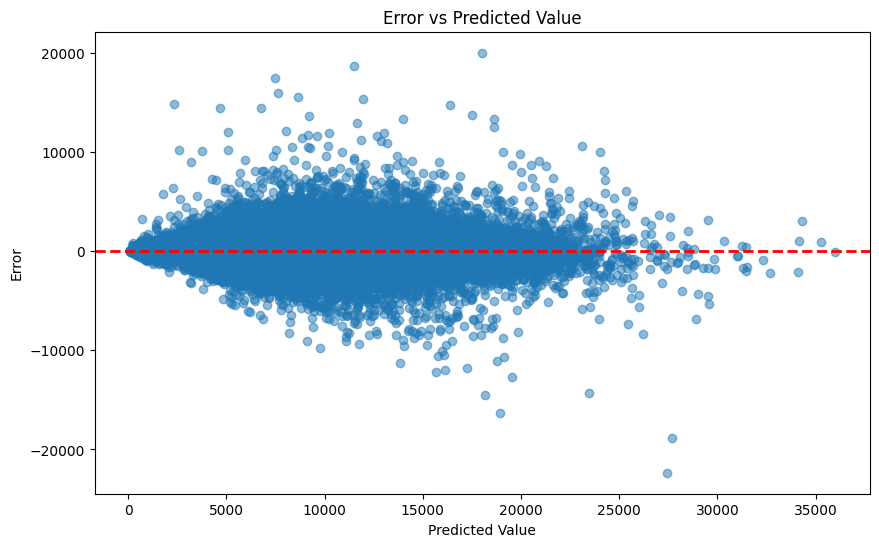

In [ ]:
errors = y_test - y_pred

# Visualise the relationship between the forecast error and the forecast value.
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Value')
plt.ylabel('Error')
plt.title('Error vs Predicted Value')
plt.show()

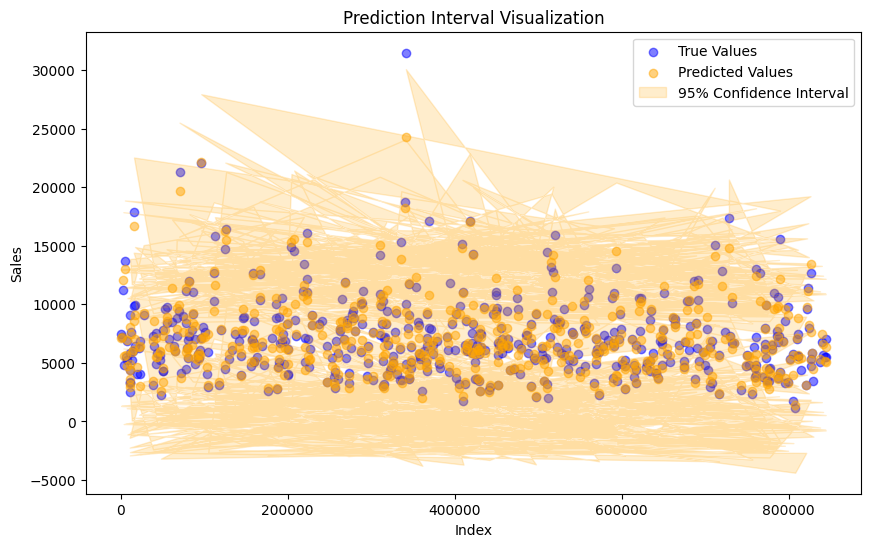

In [91]:
# Calculate the prediction intervals for 'Sales'
sales_pred = y_pred[:, 0]  # Select the 'Sales' predictions
predictions_mean = np.mean(sales_pred)
predictions_std = np.std(sales_pred)
confidence_interval = 1.96 * predictions_std  # 95% confidence interval

# Sample the data to reduce the number of markers
sampled_indices = np.linspace(0, len(y_test) - 1, 500, dtype=int)  # Sample 500 points

# Plot the prediction intervals
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index[sampled_indices], y_test['Sales'].iloc[sampled_indices], label='True Values', color='blue', alpha=0.5)
plt.scatter(y_test.index[sampled_indices], sales_pred[sampled_indices], label='Predicted Values', color='orange', alpha=0.5)
plt.fill_between(y_test.index[sampled_indices], sales_pred[sampled_indices] - confidence_interval, sales_pred[sampled_indices] + confidence_interval, color='orange', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Prediction Interval Visualization')
plt.legend()
plt.show()

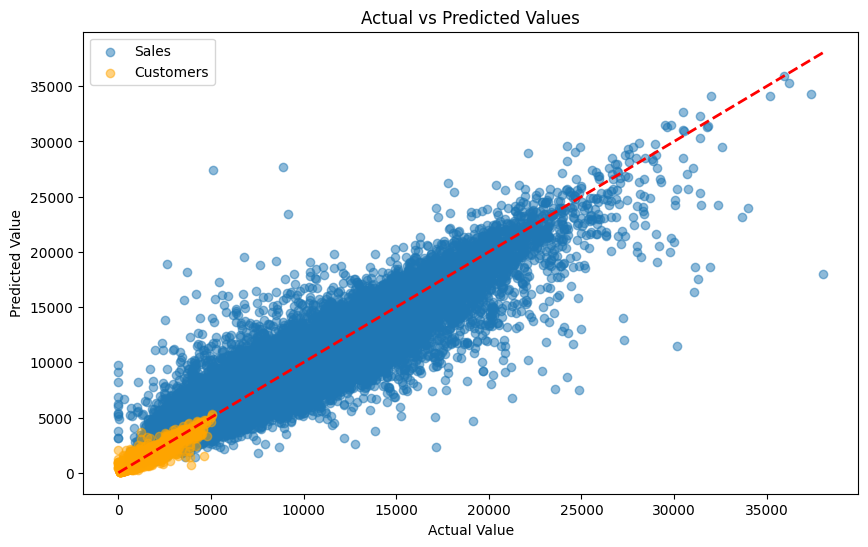

In [ ]:
# Visualisation of the relationship between actual and forecast values
plt.figure(figsize=(10, 6))
plt.scatter(y_test['Sales'], y_pred[:, 0], alpha=0.5, label='Sales')
plt.scatter(y_test['Customers'], y_pred[:, 1], alpha=0.5, label='Customers', color='orange')
plt.plot([y_test['Sales'].min(), y_test['Sales'].max()], [y_test['Sales'].min(), y_test['Sales'].max()], 'r--', lw=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [93]:
test_or = pd.read_csv('test.csv')

In [94]:
test_predictions = rf.predict(df2[features])

test_or.loc[test_or['Open'] == 0, ['Sales', 'Customers']] = 0

test_or.loc[test_or['Open'] == 1, ['Sales', 'Customers']] = test_predictions

test_or.to_csv('test_predictions.csv', index=False)

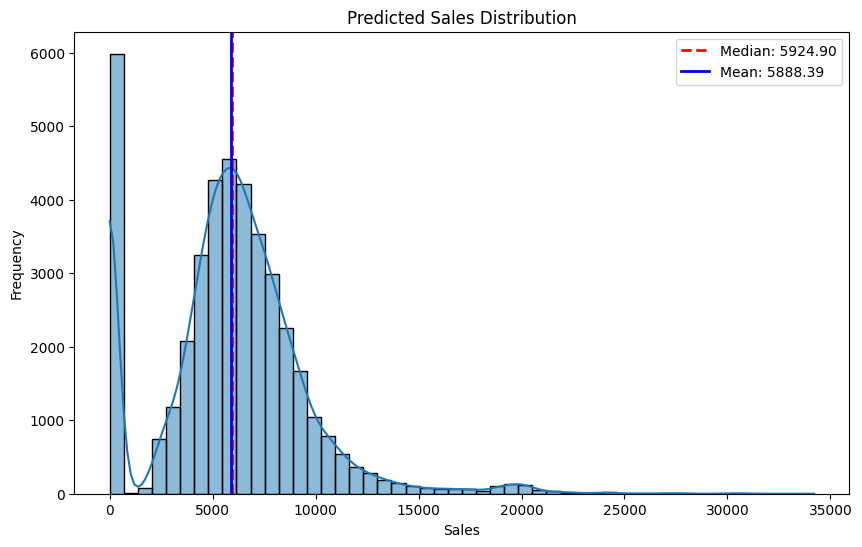

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(test_or['Sales'], bins=50, kde=True)
plt.title("Predicted Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")

median_sales = test_or['Sales'].median()
mean_sales = test_or['Sales'].mean()

plt.axvline(median_sales, color='red', linestyle='--', linewidth=2, label=f'Median: {median_sales:.2f}')
plt.axvline(mean_sales, color='blue', linestyle='-', linewidth=2, label=f'Mean: {mean_sales:.2f}')

plt.legend()

plt.show()

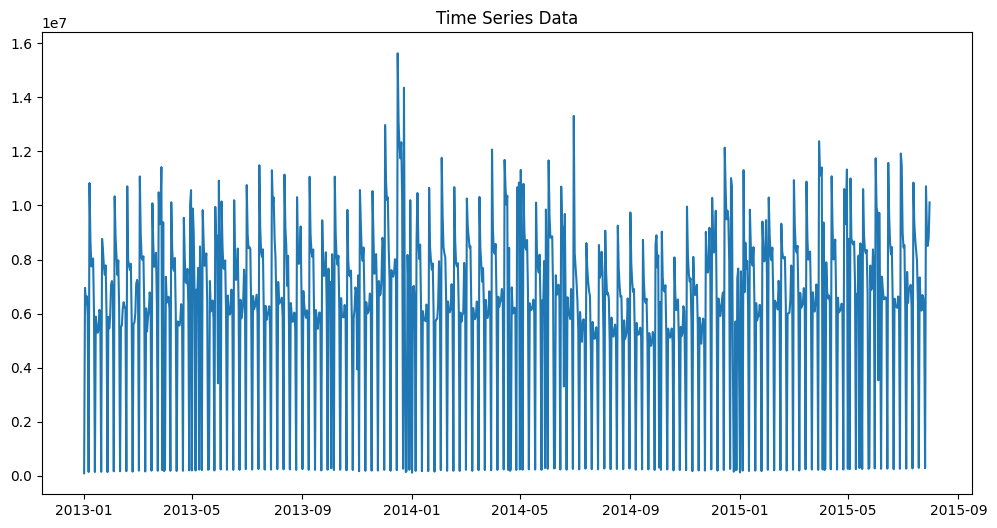

C:\Users\murui\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\murui\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\murui\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 3290805.8900924935


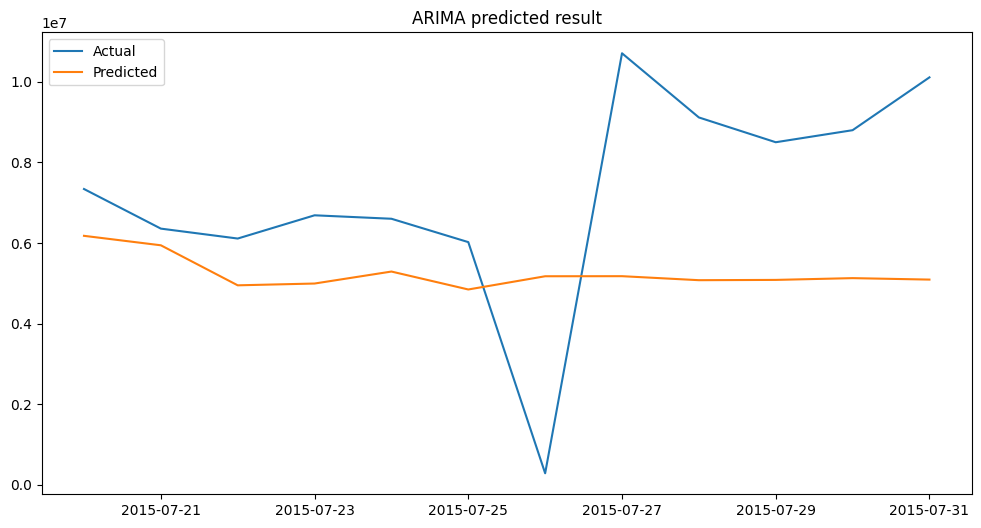

In [105]:
sales_data = train_df.groupby('Date')['Sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales_data)
plt.title('Time Series Data')
plt.show()

train_data = sales_data[:-12] 
test_data = sales_data[-12:]


model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()


predictions = model_fit.forecast(steps=len(test_data))


rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'RMSE: {rmse}')

plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA predicted result')
plt.legend()
plt.show()


In [97]:
rmspe_train = calculate_rmspe(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"R² Score: {r2:.4f}")
print(f"RMSPE: {rmspe_train:.2f}%")

R² Score: 0.9860
RMSPE: 20.66%


In [98]:
# save document
doc.save('store_data_summary.docx')